# RAVE+ - Hybrid Model

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pickle as pkl
import pickle5 as pkl5
from copy import deepcopy
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
from scipy import io
import numpy as np
from sklearn.decomposition import PCA
import json

from rave.model.architectures import Autoencoder, CustomDataParallel
from rave.model.utils import ModelOutputs
from rave.model.training import train_model
from rave.evaluation.utils import print_result_dictionary, get_sim_ground_truth_labels
from rave.evaluation.score import get_all_scores
from rave.evaluation.embed import get_embedding
from rave.evaluation.visualize import visualize_embedding_basic
from rave.data.datasets import get_bc_data

# Define paths

In [2]:
your_path_to_model_directory =  ...
your_path_to_params_file = os.path.join(your_path_to_model_directory, 'params.json')

In [3]:
your_data_directory = ...
your_dataset_file_name_A = "bc_franke_210809.pkl"
your_dataset_file_name_B = "bc_szatko_210809.pkl"

In [4]:
ipl_file1=.../ipl.mat'
ipl_file2=.../BC_Profiles_Helmstaedter.txt'

### load IPL info files

In [5]:
with open(ipl_file1, 'rb') as f:
    ipl_dict = io.loadmat(f)
with open(ipl_file2, 'rb') as f:
    ipl_depth_per_type_em = np.loadtxt(f)

# load dataset

In [6]:
type_names = ["1", "2", "3a", "3b", "4", "5t", "5o", "5i", "X", "6", "7", "8", "9", "R"]

In [7]:
dataset = get_bc_data(your_data_directory, franke_file_name="bc_franke_210809.pkl", szatko_file_name="bc_szatko_210809.pkl",verbose=True)

Splitting by Type Labels, all type labels must be in first scan
5-Fold Cross-Validation Train=9364 / Val=2342
baseline adversarial accuracy (biggest class 0.0) 0.6471040492055357
baseline cell type accuracy (biggest class 3.0) 0.12462046204620462


In [8]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train, y_type_val] = \
dataset.get_split_numpy(0)

# load model and training parameters

In [9]:
with open(your_path_to_params_file, "rb") as f:
    params = json.load(f)

# Update params to be compatible with training v1

In [11]:
config = deepcopy(params)

In [12]:
config_update = {
    "datatype":"bc",
    "data_dir" : your_data_directory,
    "data_kwargs": dict(franke_file_name = your_dataset_file_name_A,
                        szatko_file_name = your_dataset_file_name_B),
    "model_type": "hybrid",
    "model_architecture": "autoencoder"}

In [13]:
config.update(config_update)

In [14]:
config["training"]["batch_size"] = 20160
config["training"]["reconstruction_loss"] = "torch.nn.functional.mse_loss"
config["training"]["type_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["domain_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["batched_training"] = False
config["training"]["optim_step_count"] = 1

# Load model and ... 

In [15]:
model = Autoencoder(dataset.D, **config["model"])

### ... instantiate with state dict from checkpoint

In [16]:
with open(os.path.join(your_path_to_model_directory, "model.pth"), "rb") as f:
    state_dict = torch.load(f)
model.load_state_dict(state_dict)

<All keys matched successfully>

### ... or train again

In [17]:
#model = train_model(config)

In [18]:
model_output = ModelOutputs()
model_output.get_model_outputs(model, dataset)

In [19]:
num_hidden = params["model"]["num_hidden"]
print(num_hidden)

57


# run evaluation on PCA-transformed, raw data

## get PCA transform of raw data

In [20]:
pca_obj = PCA(n_components=num_hidden, whiten=True)
pca_train = pca_obj.fit_transform(x_train)

In [21]:
result_dict_raw, output_pre = get_all_scores(dataset, pca_train, pca_obj.transform(x_val),
                            pca_obj.transform(dataset.X_test), y_scan_train, y_scan_val,
                            dataset.Y_scan_test,
                       y_type_train, y_type_val, dataset.Y_type_test, 
                        dataset.ipl_depth_test,
                                             n_jobs=1,
                        conf_weighted_kde_estimate=True, correct_label_mixup=False,
                                            ipl_file1=ipl_file1,
                                            ipl_file2=ipl_file2)

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 2021}
val set accuracy: 0.999
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 0}
scan train score seed 0: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 42}
scan train score seed 1: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 1067}
scan train score seed 2: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 99}
scan train score seed 3: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 30, 'random_state': 50}
scan train score seed 4: 0.999
{'ccp_alp

In [22]:
print_result_dictionary(result_dict_raw, dataset)

Mean +- sd domain accuracy: 1.00 +- 0.001
Mean +- sd type accuracy for dataset 0: 0.83 +- 0.003
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.601 +- 0.07; 0.449
2:  0.408 +- 0.03; 0.372
3a:  0.489 +- 0.06; 0.404
3b:  0.491 +- 0.03; 0.420
4:  0.564 +- 0.05; 0.465
5t:  0.622 +- 0.03; 0.580
5o:  0.566 +- 0.05; 0.439
5i:  0.599 +- 0.02; 0.565
X:  0.644 +- 0.03; 0.587
6:  0.554 +- 0.00; 0.554
7:  0.592 +- 0.11; 0.366
8:  0.469 +- 0.11; 0.289
9:  0.522 +- 0.08; 0.321
R:  0.619 +- 0.01; 0.617
domain accuracy: 1.00 +- 0.001
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): 0.109 +- 0.03


In [23]:
print_result_dictionary(result_dict_raw, dataset)

Mean +- sd domain accuracy: 1.00 +- 0.001
Mean +- sd type accuracy for dataset 0: 0.83 +- 0.003
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.601 +- 0.07; 0.449
2:  0.408 +- 0.03; 0.372
3a:  0.489 +- 0.06; 0.404
3b:  0.491 +- 0.03; 0.420
4:  0.564 +- 0.05; 0.465
5t:  0.622 +- 0.03; 0.580
5o:  0.566 +- 0.05; 0.439
5i:  0.599 +- 0.02; 0.565
X:  0.644 +- 0.03; 0.587
6:  0.554 +- 0.00; 0.554
7:  0.592 +- 0.11; 0.366
8:  0.469 +- 0.11; 0.289
9:  0.522 +- 0.08; 0.321
R:  0.619 +- 0.01; 0.617
domain accuracy: 1.00 +- 0.001
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): 0.109 +- 0.03


# evaluate model: domain classification, type classification

In [24]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train,
         y_type_val] = dataset.get_split(0, "cpu")

In [25]:
result_dict_rave, output = get_all_scores(dataset, model_output.z_train,
              model_output.z_val,
              model_output.z_test,
              y_scan_train, y_scan_val, 
              dataset.Y_scan_test,
              y_type_train, y_type_val,
              dataset.Y_type_test,
               dataset.ipl_depth_test,
                n_jobs=1,
                ppath = None, 
                conf_weighted_kde_estimate=True,
                correct_label_mixup=False,
                 ipl_file1=ipl_file1,
                 ipl_file2=ipl_file2
              )

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 2021}
val set accuracy: 0.676
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 0}
scan train score seed 0: 0.993
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 42}
scan train score seed 1: 0.992
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 1067}
scan train score seed 2: 0.994
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 99}
scan train score seed 3: 0.994
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 50}
scan train score seed 4: 0.9

In [26]:
print_result_dictionary(result_dict_rave, dataset)

Mean +- sd domain accuracy: 0.65 +- 0.006
Mean +- sd type accuracy for dataset 0: 0.78 +- 0.005
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.374 +- 0.02; 0.340
2:  0.313 +- 0.02; 0.285
3a:  0.435 +- 0.01; 0.418
3b:  0.409 +- 0.01; 0.395
4:  0.517 +- 0.01; 0.496
5t:  0.624 +- 0.01; 0.610
5o:  0.575 +- 0.01; 0.557
5i:  0.553 +- 0.02; 0.531
X:  0.553 +- 0.01; 0.526
6:  0.265 +- 0.01; 0.252
7:  0.570 +- 0.02; 0.536
8:  0.455 +- 0.01; 0.433
9:  0.309 +- 0.02; 0.274
R:  0.340 +- 0.02; 0.304
domain accuracy: 0.65 +- 0.006
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): 0.809 +- 0.02


# Visualize ... 

### ... learned latent representations

In [27]:
embedding, embedder = get_embedding(model_output.z_test, embedding_type="tsne",
                                   embedding_kwargs=dict(initialization="pca", perplexity=20, verbose=True))

--------------------------------------------------------------------------------
TSNE(perplexity=20, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 60 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.44 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 3.1832, 50 iterations in 0.3893 sec
Iteration  100, KL divergence 2.8781, 50 iterations in 0.2843 sec
Iteration  150, KL divergence 2.8230, 50 iterations in 0.2800 sec
Iteration  200, KL divergence 2.7974, 50 iterations in 0.2789 sec
Iteration  250, KL divergence 2.7791, 50 iterations in 0.2772 sec
   --> Time elapsed: 1.51 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 

Get the type labels as predicted from classifier trained on latent representation z

In [28]:
y_type_test_rave = np.asarray([
    np.argmax(np.bincount(temp.astype(int), minlength=14)) for temp in result_dict_rave["y_type_test_post"]])

(<Figure size 360x720 with 4 Axes>,
 TSNEEmbedding([[ 12.9359965 , -32.39064169],
                [ 14.41718134, -24.92216816],
                [ 14.67200651, -33.03113532],
                ...,
                [-30.94084316,  23.66662422],
                [-35.83510503,   0.45540373],
                [-30.7988097 ,  -4.47553984]]),
 TSNE(perplexity=20, random_state=42, verbose=True))

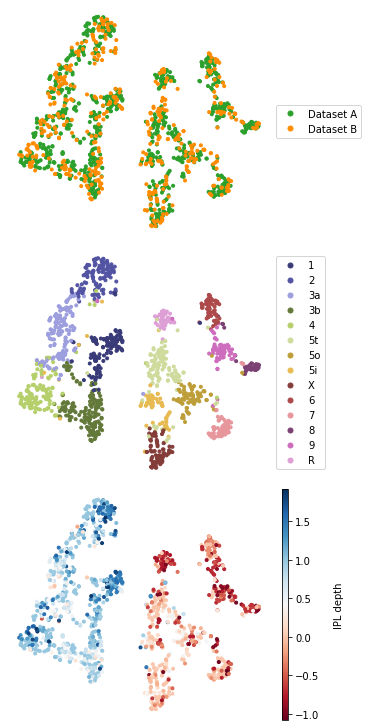

In [29]:
visualize_embedding_basic(model, dataset, datatier="test",
                          embedder=embedder, embedding=embedding,
                          type_label=y_type_test_rave)

# Perform IPL depth distribution analysis

In [30]:
from rave.evaluation.visualize import depth_dist_plots

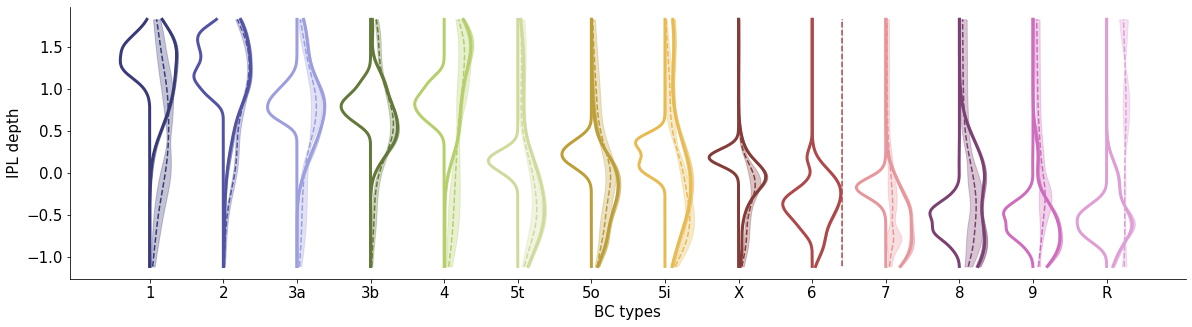

In [31]:
with mpl.rc_context({"font.size":15, "lines.linewidth" : 3}):
    depth_dist_plots(ipl_depth_per_type_em, 
                     res_dict=dict(kde_per_type=result_dict_rave["kde_per_type_all"]),
                     res_dict_raw=dict(kde_per_type=result_dict_raw["kde_per_type_all"]),
                     ipl_depth_em_dict=ipl_dict,
                     fname=""
                )